Name: Patrick Doran  
Student Number: 21261768

# Lab 5: Regression and Dimensionality Reduction

This exercise repeats the same scenario as Lab 4, but this time we train a regression model, i.e. a model for numeric prediction. We also add dimensionality reduction element to the training pipeline. Note that dimensionality reduction can be included in classification pipelines in the same way. 

In this exercise we use the `fish market` dataset, taken from https://www.kaggle.com/aungpyaeap/fish-market. Each example in this dataset represents a fish. The first column is the name of the fish species and the other six columns are numerical characteristics of the fish. 

In this exercise, we aim at training a regression model for predicting the weight of a fish from its other characteristics. We will evaluate two regression algorithms, `RandomForestRegressor` and `LinearRegression`, to choose the better one for training the final model.

In [69]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

We start with a brief EDA to check for missing values and outliers.

In [70]:
df = pd.read_csv("insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [71]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

No big suprises here. Might need to encode the cathegorical data

In [72]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [73]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

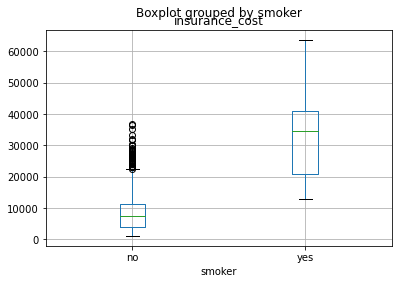

In [74]:
df.boxplot(column = 'insurance_cost', by = 'smoker');

There seems to be a considerable number of non smokers paying over the odds for their insurance. I wonder if this could be down to BMI or age. 

Now, let's check for missing values and outliers.

In [75]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes.

In [76]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

These all look okay, the maximum price for insurance seems wild.

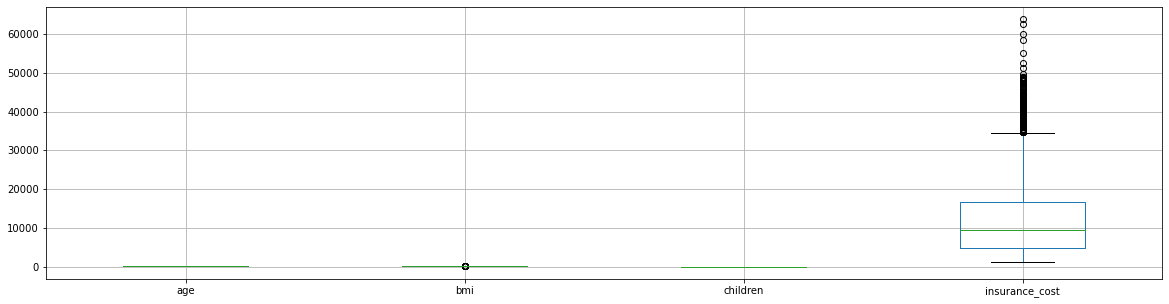

In [77]:
df.boxplot(figsize=(20,5));

As I expected insurance cost has a significant amount of outliers, will need to use a robust scaler to deal with these


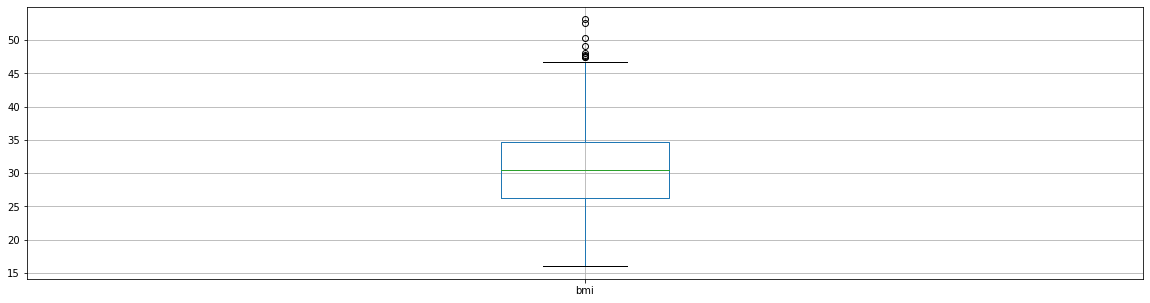

In [78]:
df.boxplot(column = ['bmi'], figsize=(20,5));

Because DMI is on a much smaller scale range, we could not see the outliers in the previous plot. There are very few outliers here, so I will just use a standard scaler to scale these.

## Data Preparation

I will one hot encode smoker & gender, and map region

In [79]:
df = pd.get_dummies(df, columns=['smoker', 'gender'], 
                        #dummy_na=True, 
                        drop_first=True)

In [80]:
df

age     bmi  children     region  insurance_cost  smoker_yes  \
0      18  33.770         1  southeast      1725.55230           0   
1      18  34.100         0  southeast      1137.01100           0   
2      18  26.315         0  northeast      2198.18985           0   
3      18  38.665         2  northeast      3393.35635           0   
4      18  35.625         0  northeast      2211.13075           0   
...   ...     ...       ...        ...             ...         ...   
1333   64  31.825         2  northeast     16069.08475           0   
1334   64  26.885         0  northwest     29330.98315           1   
1335   64  26.410         0  northeast     14394.55790           0   
1336   64  36.960         2  southeast     49577.66240           1   
1337   64  23.760         0  southeast     26926.51440           1   

      gender_male  
0               1  
1               1  
2               0  
3               0  
4               0  
...           ...  
1333            0  
1334            0  
1335            1  
1336            1  
1337            1  

[1338 rows x 7 columns]

#### Feature Engineering

In [81]:
df['long']=df['region'].str[:5]
df['lat']=df['region'].str[5:]
df_a = df.drop(['region'], axis=1)
df

age     bmi  children     region  insurance_cost  smoker_yes  \
0      18  33.770         1  southeast      1725.55230           0   
1      18  34.100         0  southeast      1137.01100           0   
2      18  26.315         0  northeast      2198.18985           0   
3      18  38.665         2  northeast      3393.35635           0   
4      18  35.625         0  northeast      2211.13075           0   
...   ...     ...       ...        ...             ...         ...   
1333   64  31.825         2  northeast     16069.08475           0   
1334   64  26.885         0  northwest     29330.98315           1   
1335   64  26.410         0  northeast     14394.55790           0   
1336   64  36.960         2  southeast     49577.66240           1   
1337   64  23.760         0  southeast     26926.51440           1   

      gender_male   long   lat  
0               1  south  east  
1               1  south  east  
2               0  north  east  
3               0  north  east  
4               0  north  east  
...           ...    ...   ...  
1333            0  north  east  
1334            0  north  west  
1335            1  north  east  
1336            1  south  east  
1337            1  south  east  

[1338 rows x 9 columns]

In [82]:
df_a['long'].value_counts()

south    689
north    649
Name: long, dtype: int64

In [83]:
df_a['lat'].value_counts()

east    688
west    650
Name: lat, dtype: int64

In [84]:
df_b = pd.get_dummies(df_a, columns=['long', 'lat'], 
                        #dummy_na=True, 
                        drop_first=True)

In [85]:
df_b

age     bmi  children  insurance_cost  smoker_yes  gender_male  \
0      18  33.770         1      1725.55230           0            1   
1      18  34.100         0      1137.01100           0            1   
2      18  26.315         0      2198.18985           0            0   
3      18  38.665         2      3393.35635           0            0   
4      18  35.625         0      2211.13075           0            0   
...   ...     ...       ...             ...         ...          ...   
1333   64  31.825         2     16069.08475           0            0   
1334   64  26.885         0     29330.98315           1            0   
1335   64  26.410         0     14394.55790           0            1   
1336   64  36.960         2     49577.66240           1            1   
1337   64  23.760         0     26926.51440           1            1   

      long_south  lat_west  
0              1         0  
1              1         0  
2              0         0  
3              0         0  
4              0         0  
...          ...       ...  
1333           0         0  
1334           0         1  
1335           0         0  
1336           1         0  
1337           1         0  

[1338 rows x 8 columns]

#### Outliers

In [86]:
# Not Used
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [87]:
# Not Used
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [88]:
# store a list with the names of all predictors
names_all = [c for c in df_b]

# define column groups with same data preparation
names_outliers = ['insurance_cost']
names_no_outliers = list(set(names_all) - set(names_outliers))

#### setting up pipline and Splitting data

Since insurance cost is my target variable, I'm not sure if I should scale it or not. I think if I don't scale it some of my evaluation metrics may be lower than expected.

In [89]:
y = df_b['insurance_cost']
X = df_b.drop('insurance_cost', axis=1).values

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [91]:
preprocess_pipeline = make_pipeline(StandardScaler())

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [92]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [93]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), PCA(iterated_power=5)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.860:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

### Linear Regression Pipeline

In [94]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [98]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]


param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.750:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model

### XGboost Regression

https://machinelearningmastery.com/xgboost-for-regression/
https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods

pip install xgboost

In [99]:
from sklearn.svm import SVR
import xgboost
from xgboost.sklearn import XGBRegressor

In [100]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),  # passthrough just means None pretty much. We are defining dimension reduction in gridsearch
                       ('regresson', XGBRegressor())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [101]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
    
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
XG_best_params = search.best_params_
XG_best_model = search.best_estimator_
#XG_PCA_components = search.best_estimator_.named_steps['reduce_dim'].components_
#XG_PCA_explained_v = search.best_estimator_.named_steps['reduce_dim'].explained_variance_
#print(pd.DataFrame(XG_PCA_components,columns=df_b.columns,index = ['PC-1','PC-2']))

Best CV score = 0.857:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 2}


### SVR

In [102]:
from sklearn.svm import SVR
from sklearn.decomposition import KernelPCA

In [103]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', SVR(gamma = 'auto'))])

In [104]:
N_FEATURES_OPTIONS = [2, 6, 11]
KERNEL = ['rbf', 'linear']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL
    },
    {
        'reduce_dim': [KernelPCA(kernel = 'rbf')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL
    }, 
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__kernel': KERNEL
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_

Best CV score = -0.041:
Best parameters:  {'reduce_dim': PCA(iterated_power=7, n_components=6), 'reduce_dim__n_components': 6, 'regresson__kernel': 'linear'}


My support vector machine, doesn't seem to be working well for this. 

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [105]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [106]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
XG_mse, XG_mae, XG_r2 = evaluate_model(X_test, y_test, XG_best_model)

We will use a Pandas bar plots to compare the results. 

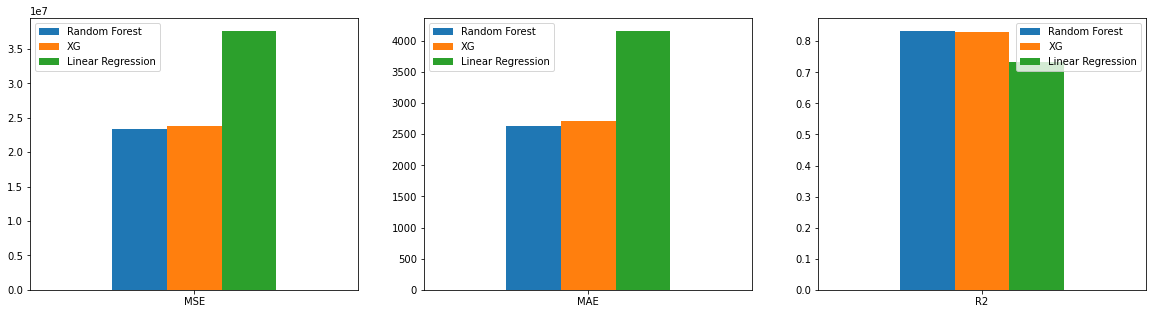

In [107]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'XG': XG_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'XG': XG_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'XG': XG_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

This tests confirms that Random Forest is the better regression model with lower MSE and MAE and higher R2.

### Reflection:
Here you can see that the random forest model has the best performance. It has the lowest MSE and MAE and the highest R2 scores. This means it has the lowest error and the r2 score shows us that it has the lowest variance. XGboost was a close second, and linear regression lagged behind. I have since added support vector machine, which I have always considered to be a very effective model. It does not seem to work well in this case. I will need to explore the reason for this further. 

I was suprised to see that the gridsearchcv selected RFE (recursive feature elimination) over PCA (prinicple component analysis) for each of the models. One key advantage of using PCA is to extract the feature importance from the model. I am not sure if this can be done with RFE, but I will need to explore this further. 

I have struggled to get my head around how pipeline and gridsearchcv sv work in tandom. Following the webinar on Wednesday night, pipeline makes much more sense. I didn't realise that passthrough just allowed you to add a model of your choice in gridsearchcv. 



## Task 3

https://machinelearningmastery.com/dimensionality-reduction-algorithms-with-python/

### KernalPCA

In [108]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [109]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    
    {
        'reduce_dim': [KernelPCA('linear'), KernelPCA('rbf')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
y_train1 = y_train.astype('int')
search.fit(X_train, y_train1)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KPCA_best_params = search.best_params_
KPCA_best_model = search.best_estimator_


Best CV score = 0.765:
Best parameters:  {'reduce_dim': KernelPCA(n_components=11), 'reduce_dim__n_components': 11, 'regresson__max_depth': 8}


### LDA Linear Discriminant Analysis

In [110]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [111]:
from sklearn.linear_model import LogisticRegression

In [112]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [113]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    
    {
        'reduce_dim': [LDA(solver = 'svd'), LDA(solver = 'lsqr'), LDA(solver = 'eigen')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
y_train1 = y_train.astype('int')
search.fit(X_train, y_train1)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LDA_best_params = search.best_params_
LDA_best_model = search.best_estimator_


Best CV score = 0.602:
Best parameters:  {'reduce_dim': LinearDiscriminantAnalysis(n_components=6), 'reduce_dim__n_components': 6, 'regresson__max_depth': 6}


This model didn't preform well when compared to other models

### ISomap Embedding
https://machinelearningmastery.com/dimensionality-reduction-algorithms-with-python/

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html

In [114]:
from sklearn.manifold import Isomap

In [115]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [116]:
N_FEATURES_OPTIONS = [2, 6, 11]
N_NEIGHBORS = [2, 5, 7, 10]
NEIGHBOR_AL = ['auto', 'brute', 'kd_tree', 'ball_tree']
EIGEN_SOLVR = ['auto', 'arpack']
NORMALIZE_OPTIONS = [False, True]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    
    {
        'reduce_dim': [Isomap()],
        'reduce_dim__n_neighbors': N_NEIGHBORS,
        'reduce_dim__eigen_solver': EIGEN_SOLVR,
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
ISO_best_params = search.best_params_
ISO_best_model = search.best_estimator_

Best CV score = 0.754:
Best parameters:  {'reduce_dim': Isomap(eigen_solver='arpack', n_components=11, n_neighbors=10), 'reduce_dim__eigen_solver': 'arpack', 'reduce_dim__n_components': 11, 'reduce_dim__n_neighbors': 10, 'regresson__max_depth': 8}


In [120]:
RFE_mse, RFE_mae, RFE_r2 = evaluate_model(X_test, y_test, RF_best_model)
ISO_mse, ISO_mae, ISO_r2 = evaluate_model(X_test, y_test, ISO_best_model)
LDA_mse, LDA_mae, LDA_r2 = evaluate_model(X_test, y_test, LDA_best_model)
KPCA_mse, KPCA_mae, KPCA_r2 = evaluate_model(X_test, y_test, KPCA_best_model)

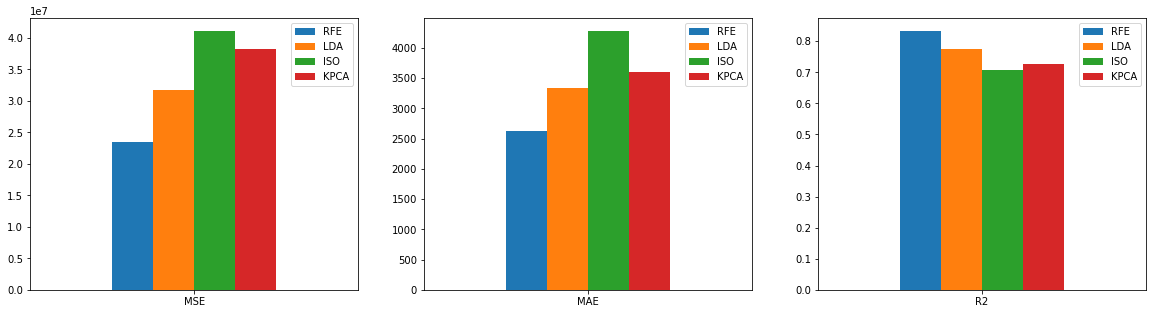

In [121]:
df_mse = pd.DataFrame({'RFE': RFE_mse, 'LDA': LDA_mse, 'ISO': ISO_mse, 'KPCA': KPCA_mse}, index=['MSE'])
df_mae = pd.DataFrame({'RFE': RFE_mae, 'LDA': LDA_mae, 'ISO': ISO_mae, 'KPCA': KPCA_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'RFE': RFE_r2, 'LDA': LDA_r2, 'ISO': ISO_r2, 'KPCA': KPCA_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### Reflection
I decided to keep the regressor constant while I varied the dimensionality reduction model. This allowed me to compare the models on an even footing. Across the models. I saw relatively good performance. I am surprised by the results because they do not aline with the cv scores. It seems as though the ISOmapping model did not generalise well to the test data where as LDA outpreformed its CV score on the test data.

Althought it was not requested in the etivity I am very interested to extract the feature importances. I also wonder how the regresion would have preformed without reducing the number of features. If I have time to review this, it might be an interesting comparision

## Train a Final Model

Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [23]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline,
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [24]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))